In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  2 08:27:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
!pip install cutmix-keras

In [ ]:
from cutmix_keras import CutMixImageDataGenerator  # Import CutMix

In [ ]:
#mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/train.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/n04579145/n04579145_944.JPEG  
  inflating: train/n04579145/n04579145_95.JPEG  
   creating: train/n04579432/
  inflating: train/n04579432/n04579432_10070.JPEG  
  inflating: train/n04579432/n04579432_10312.JPEG  
  inflating: train/n04579432/n04579432_10843.JPEG  
  inflating: train/n04579432/n04579432_11773.JPEG  
  inflating: train/n04579432/n04579432_12525.JPEG  
  inflating: train/n04579432/n04579432_12929.JPEG  
 extracting: train/n04579432/n04579432_145.JPEG  
  inflating: train/n04579432/n04579432_14806.JPEG  
  inflating: train/n04579432/n04579432_14913.JPEG  
  inflating: train/n04579432/n04579432_15260.JPEG  
  inflating: train/n04579432/n04579432_16138.JPEG  
  inflating: train/n04579432/n04579432_16784.JPEG  
  inflating: train/n04579432/n04579432_17230.JPEG  
  inflating: train/n04579432/n04579432_17415.JPEG  
  inflating: train/n04579432/n04579432_17945.JPEG  
  inflating: train/n04579432/n04579432_184

In [ ]:
# !unzip '/content/drive/MyDrive/test.zip'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
tf.__version__

'2.8.0'

In [ ]:
def normalize_image(image, mean, std):
    for channel in range(3):
        image[:,:,channel] = (image[:,:,channel] - mean[channel]) / std[channel]
    return image

def random_crop_normalize(img, random_crop_size,mean,std):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return normalize_image(img[y:(y+dy), x:(x+dx), :],mean,std)

def center_crop_normalize(img, crop_size,mean,std):
    height, width = img.shape[0], img.shape[1]
    dy, dx = crop_size
    x = (width - dx + 1) // 2
    y = (height - dy + 1) // 2
    return normalize_image(img[y:(y+dy), x:(x+dx), :],mean,std)

def random_crop_normalize_generator(batches, crop_length,mean,std):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop_normalize(batch_x[i], (crop_length, crop_length), mean, std)
        yield (batch_crops, batch_y)
        
def center_crop_normalize_generator(batches, crop_length,mean,std):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = center_crop_normalize(batch_x[i], (crop_length, crop_length), mean, std)
        yield (batch_crops, batch_y)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                   validation_split=0.2)

training_set1 = train_datagen.flow_from_directory('./train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training',
                                                 shuffle=True,  # Required
                                                  )
training_set2 = train_datagen.flow_from_directory('./train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training',
                                                 shuffle=True,  # Required
                                                  )
# !! Define CutMixImageDataGenerator !!
training_set = CutMixImageDataGenerator(generator1=training_set1,
                                        generator2=training_set2,
                                        img_size=256,
                                        batch_size=32)

validation_set = train_datagen.flow_from_directory('./train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')



Found 40000 images belonging to 1000 classes.
Found 40000 images belonging to 1000 classes.
Found 10000 images belonging to 1000 classes.


In [ ]:
training_set.get_steps_per_epoch()

1250

In [ ]:
training_set_cropped = random_crop_normalize_generator(training_set, 224, mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
validation_set_cropped = center_crop_normalize_generator(validation_set, 224, mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

In [ ]:
base_model=tf.keras.applications.ResNet50(
    include_top=True,
    weights='drive/MyDrive/SGD_AV_wo_aug.h5',
    input_shape=(224,224,3),classes=1000)


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in base_model.layers:
  print(layer.name,end=",")

input_1,conv1_pad,conv1_conv,conv1_bn,conv1_relu,pool1_pad,pool1_pool,conv2_block1_1_conv,conv2_block1_1_bn,conv2_block1_1_relu,conv2_block1_2_conv,conv2_block1_2_bn,conv2_block1_2_relu,conv2_block1_0_conv,conv2_block1_3_conv,conv2_block1_0_bn,conv2_block1_3_bn,conv2_block1_add,conv2_block1_out,conv2_block2_1_conv,conv2_block2_1_bn,conv2_block2_1_relu,conv2_block2_2_conv,conv2_block2_2_bn,conv2_block2_2_relu,conv2_block2_3_conv,conv2_block2_3_bn,conv2_block2_add,conv2_block2_out,conv2_block3_1_conv,conv2_block3_1_bn,conv2_block3_1_relu,conv2_block3_2_conv,conv2_block3_2_bn,conv2_block3_2_relu,conv2_block3_3_conv,conv2_block3_3_bn,conv2_block3_add,conv2_block3_out,conv3_block1_1_conv,conv3_block1_1_bn,conv3_block1_1_relu,conv3_block1_2_conv,conv3_block1_2_bn,conv3_block1_2_relu,conv3_block1_0_conv,conv3_block1_3_conv,conv3_block1_0_bn,conv3_block1_3_bn,conv3_block1_add,conv3_block1_out,conv3_block2_1_conv,conv3_block2_1_bn,conv3_block2_1_relu,conv3_block2_2_conv,conv3_block2_2_bn,conv3_

In [ ]:
layer_name = "conv5_block3_out"
model1 = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
model1.trainable = False

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = model1(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1000,activation='softmax')(x)
model2 = tf.keras.Model(inputs, outputs)

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
Total params: 25,636,712
Trainable params: 2,049,000
Non-trainable params: 23,587,712
_______________________________________

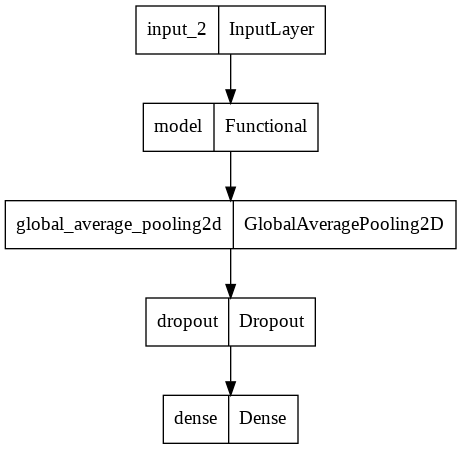

In [ ]:
tf.keras.utils.plot_model(model2)

In [ ]:
model2.compile(optimizer= tfa.optimizers.SGDW(learning_rate=0.1, momentum=0.9, nesterov=False,weight_decay=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("./drive/MyDrive/Cutmix_SGD_AV1.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 50, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped
def scheduler(epoch, lr):
  return(0.1*(0.1 ** ((epoch) // 30)))

lr_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
# we put our call backs into a callback list
callbacks = [earlystop,checkpoint,lr_scheduler]


In [ ]:
model2.fit(training_set_cropped, steps_per_epoch = training_set.samples // 32,epochs = 100, 
               batch_size = 32,validation_data=validation_set_cropped,
               validation_steps = validation_set.samples // 32,
               callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.1.
Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 6.9223 - accuracy: 0.1295
Epoch 1: val_accuracy improved from -inf to 0.14704, saving model to ./drive/MyDrive/Cutmix_SGD_AV1.h5
1250/1250 [==============================] - 625s 491ms/step - loss: 6.9223 - accuracy: 0.1295 - val_loss: 6.6109 - val_accuracy: 0.1470 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.1.
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 6.8037 - accuracy: 0.1905
Epoch 2: val_accuracy improved from 0.14704 to 0.17117, saving model to ./drive/MyDrive/Cutmix_SGD_AV1.h5
1250/1250 [==============================] - 578s 463ms/step - loss: 6.8037 - accuracy: 0.1905 - val_loss: 6.4105 - val_accuracy: 0.1712 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.1.
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 6.7478 - accuracy: 0.2097
Epoch 3: